## Load the necessery library

In [73]:

import math
import io
import torch
from torchvision import transforms
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt

from pytorch_msssim import ms_ssim

import os
from torchvision.datasets import ImageFolder

## Load the model in compressAI
*  **Cheng2020** : `cheng2020_attn`   
    Self-attention model variant from “Learned Image Compression with Discretized Gaussian Mixture Likelihoods and Attention Modules”, by Zhengxue Cheng, Heming Sun, Masaru Takeuchi, Jiro Katto.

* **Minnen2018** : `mbt2018`    
    Joint Autoregressive Hierarchical Priors model from D. Minnen, J. Balle, G.D. Toderici: “Joint Autoregressive and Hierarchical Priors for Learned Image Compression”, Adv. in Neural Information Processing Systems 31 (NeurIPS 2018). 

In [74]:
from compressai.zoo import (mbt2018, cheng2020_attn)

In [75]:
from ipywidgets import interact, widgets

## Global settings

In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
metric = 'mse'  # only pre-trained model for mse are available for now

## Load the Model in "The Devil Is in the Details: Window-based Attention for Image Compression"

In [77]:
from compressai.models import WACNN
from compressai.models import SymmetricalTransFormer

## Load input data

In [78]:
img = Image.oimg = Image.open('./assets/kodim08.png').convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)

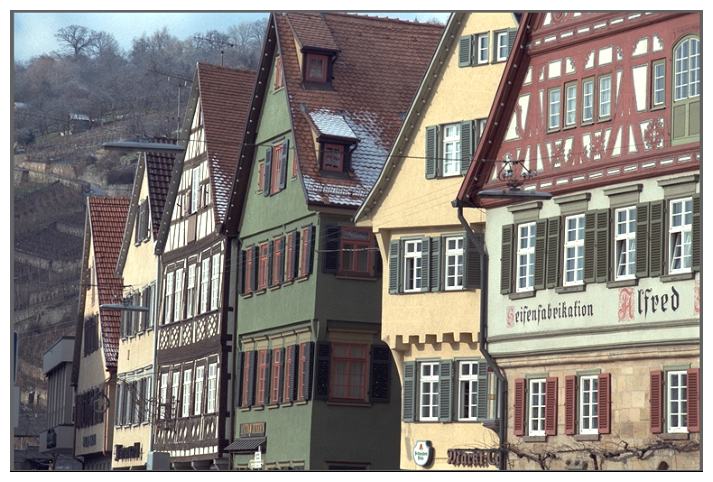

In [79]:
%matplotlib inline
plt.figure(figsize=(9, 6))
plt.axis('off')
plt.imshow(img)
plt.show()

In [80]:
img2 = Image.oimg = Image.open('../eval_dataset/CLIC_professional_valid_2020/alberto-montalesi-176097.png').convert('RGB')

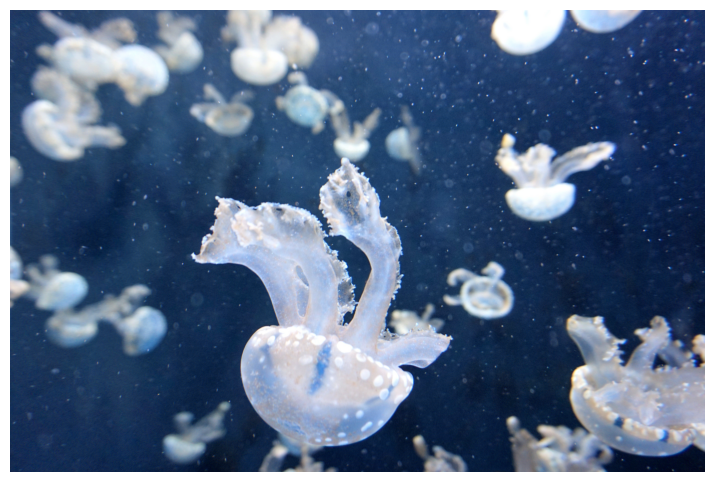

In [81]:
%matplotlib inline
plt.figure(figsize=(9, 6))
plt.axis('off')
plt.imshow(img2)
plt.show()

## Metrics

In [66]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

## Evaluate

### Define Function

In [82]:
def evaluate_model_on_dataset(net, dataset_path):
    # 初始化累積指標
    total_psnr = 0
    total_msssim = 0
    total_bpp = 0
    
    # 遍歷資料夾中的所有圖片
    for img_name in os.listdir(dataset_path):
        if img_name.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(dataset_path, img_name)
            # 載入和預處理圖片
            img = Image.open(img_path)
            x = transforms.ToTensor()(img).unsqueeze(0).to(device)
            
            # 評估單張圖片
            with torch.no_grad():
                rv = net(x)
                rv['x_hat'].clamp_(0, 1)
                
                psnr = compute_psnr(x, rv["x_hat"])
                ms_ssim = compute_msssim(x, rv["x_hat"])
                bpp = compute_bpp(rv)
                
                total_psnr += psnr
                total_msssim += ms_ssim
                total_bpp += bpp
    
    # 計算平均值
    num_images = len([f for f in os.listdir(dataset_path) 
                     if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
    
    return {
        'psnr': total_psnr / num_images,
        'ms-ssim': total_msssim / num_images,
        'bit-rate': total_bpp / num_images,
    }

### Kodak

#### Define data path

In [68]:
data_path = "../eval_dataset/kodak/"

#### Evaluate WACNN and STF

In [69]:
lambda_values = ['0018', '0035', '0067', '025']
metrics = {
    'WACNN': {'bit-rate': [], 'psnr': [], 'ms-ssim': []},
    'STF': {'bit-rate': [], 'psnr': [], 'ms-ssim': []}
}

print('-'*80)
print(f"{'Model':10s} {'Lambda':10s} | {'PSNR [dB]'} | {'MS-SSIM':9s} | {'Bpp':9s}|")
print('-'*80)

for lambda_val in lambda_values:
    # Evaluate WACNN    
    cnn_path = f"../ckpt/cnn_{lambda_val}_best.pth.tar"
    cnn_checkpoint = torch.load(cnn_path, map_location=device)
    cnn_state_dict = {k.replace('module.', ''): v for k, v in cnn_checkpoint['state_dict'].items()}
    wacnn_model = WACNN(N=192, M=320).to(device)
    wacnn_model.load_state_dict(cnn_state_dict)
    wacnn_model.eval()
    wacnn_model.update(force=True)
    
    results = evaluate_model_on_dataset(wacnn_model, data_path)
    metrics['WACNN']['bit-rate'].append(results['bit-rate'])
    metrics['WACNN']['psnr'].append(results['psnr'])
    metrics['WACNN']['ms-ssim'].append(results['ms-ssim'])
    
    print(f"{'WACNN':10s} {lambda_val:10s}", end='')
    print(f" | {results['psnr']:9.3f}", end='')
    print(f" | {results['ms-ssim']:9.3f}", end='')
    print(f" | {results['bit-rate']:9.3f}|")
    
    # Evaluate STF
    stf_path = f"../ckpt/stf_{lambda_val}_best.pth.tar"
    stf_checkpoint = torch.load(stf_path, map_location=device)
    stf_state_dict = {k.replace('module.', ''): v for k, v in stf_checkpoint['state_dict'].items()}
    stf_model = SymmetricalTransFormer(
        pretrain_img_size=256,
        patch_size=2,
        embed_dim=48,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=4,
        num_slices=12
    ).eval().to(device)
    stf_model.load_state_dict(stf_state_dict)
    
    results = evaluate_model_on_dataset(stf_model, data_path)
    metrics['STF']['bit-rate'].append(results['bit-rate'])
    metrics['STF']['psnr'].append(results['psnr'])
    metrics['STF']['ms-ssim'].append(results['ms-ssim'])
    
    print(f"{'STF':10s} {lambda_val:10s}", end='')
    print(f" | {results['psnr']:9.3f}", end='')
    print(f" | {results['ms-ssim']:9.3f}", end='')
    print(f" | {results['bit-rate']:9.3f}|")
    print('-'*80)

--------------------------------------------------------------------------------
Model      Lambda     | PSNR [dB] | MS-SSIM   | Bpp      |
--------------------------------------------------------------------------------
WACNN      0018       |    29.205 |     0.931 |     0.127|
STF        0018       |    28.895 |     0.927 |     0.115|
--------------------------------------------------------------------------------
WACNN      0035       |    30.745 |     0.952 |     0.200|
STF        0035       |    30.387 |     0.950 |     0.184|
--------------------------------------------------------------------------------
WACNN      0067       |    32.293 |     0.968 |     0.298|
STF        0067       |    32.136 |     0.968 |     0.299|
--------------------------------------------------------------------------------
WACNN      025        |    35.903 |     0.986 |     0.648|
STF        025        |    35.808 |     0.985 |     0.641|
----------------------------------------------------------------

#### Evaluate baseline model


In [24]:
selected_qualities = [1, 2, 3, 5]
baseline_metrics = {
    'Minnen2018': {'bit-rate': [], 'psnr': [], 'ms-ssim': []},
    'Cheng2020': {'bit-rate': [], 'psnr': [], 'ms-ssim': []}
}

print("\nBaseline Models:")
print('-'*80)
print(f"{'Model':10s} {'Quality':10s} | {'PSNR [dB]'} | {'MS-SSIM':9s} | {'Bpp':9s}|")
print('-'*80)

for quality in selected_qualities:
    networks = {
        'Minnen2018': mbt2018(quality=quality, pretrained=True).eval().to(device),
        'Cheng2020': cheng2020_attn(quality=quality, pretrained=True).eval().to(device),
    }
    
    for name, net in networks.items():
        results = evaluate_model_on_dataset(net, data_path)
        baseline_metrics[name]['bit-rate'].append(results['bit-rate'])
        baseline_metrics[name]['psnr'].append(results['psnr'])
        baseline_metrics[name]['ms-ssim'].append(results['ms-ssim'])
        
        print(f"{name:10s} {str(quality):10s}", end='')
        print(f" | {results['psnr']:9.3f}", end='')
        print(f" | {results['ms-ssim']:9.3f}", end='')
        print(f" | {results['bit-rate']:9.3f}|")
    print('-'*80)


Baseline Models:
--------------------------------------------------------------------------------
Model      Quality    | PSNR [dB] | MS-SSIM   | Bpp      |
--------------------------------------------------------------------------------
Minnen2018 1          |    28.115 |     0.922 |     0.110|
Cheng2020  1          |    28.465 |     0.926 |     0.114|
--------------------------------------------------------------------------------
Minnen2018 2          |    29.635 |     0.943 |     0.195|
Cheng2020  2          |    29.794 |     0.946 |     0.173|
--------------------------------------------------------------------------------
Minnen2018 3          |    31.387 |     0.963 |     0.288|
Cheng2020  3          |    31.351 |     0.964 |     0.268|
--------------------------------------------------------------------------------
Minnen2018 5          |    35.143 |     0.984 |     0.634|
Cheng2020  5          |    35.023 |     0.984 |     0.593|
----------------------------------------------

#### Plot

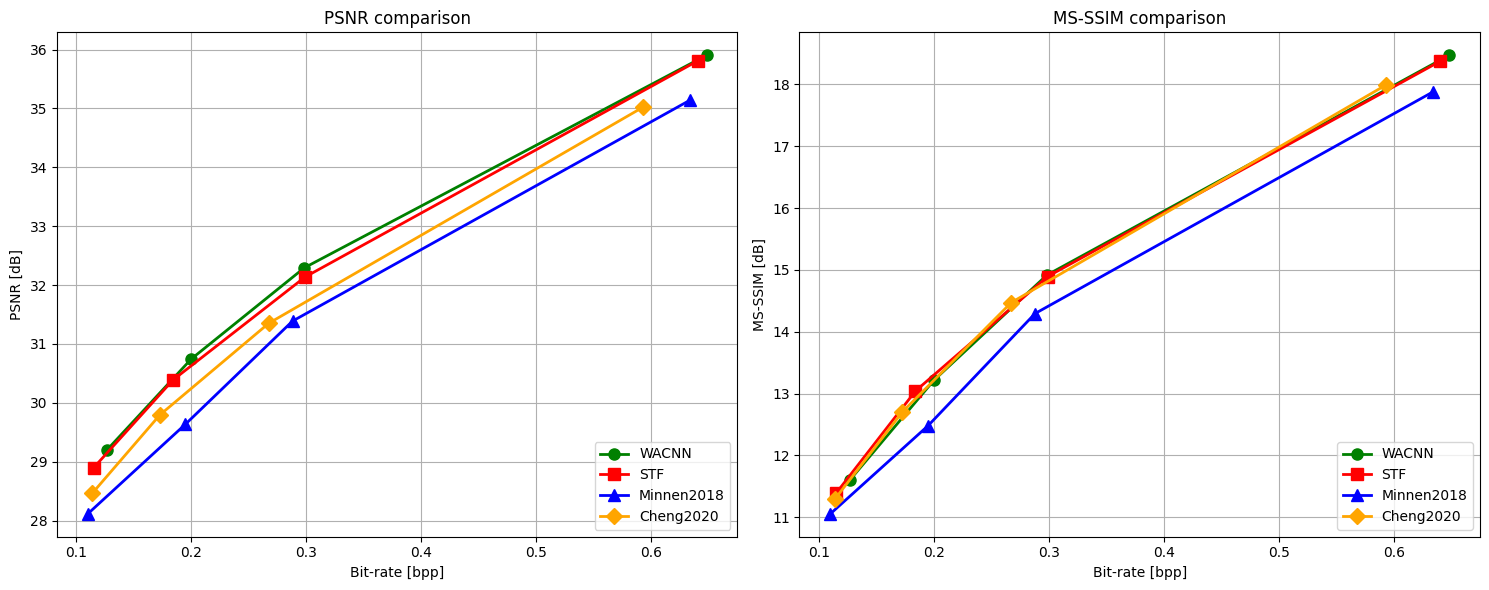

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

all_metrics = {**metrics, **baseline_metrics}

markers = {'WACNN': 'o', 'STF': 's',  'Cheng2020': 'D' , 'Minnen2018': '^'}
colors = {'WACNN': 'green', 'STF': 'red', 'Cheng2020': 'orange', 'Minnen2018': 'blue'}

for name, m in all_metrics.items():
    points = sorted(zip(m['bit-rate'], m['psnr'], m['ms-ssim']))
    bit_rates, psnrs, ms_ssims = zip(*points)
    
    # PSNR plot
    axes[0].plot(bit_rates, psnrs, f'-', color=colors[name], marker=markers[name], 
                label=name, markersize=8, linewidth=2)
    axes[0].legend(loc='lower right')
    axes[0].grid(True)
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')

    # MS-SSIM plot
    ms_ssim_db = [-10*np.log10(1-msssim) for msssim in ms_ssims]
    axes[1].plot(bit_rates, ms_ssim_db, f'-', color=colors[name], marker=markers[name], 
                label=name, markersize=8, linewidth=2)
    axes[1].legend(loc='lower right')
    axes[1].grid(True)
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM comparison')

plt.tight_layout()
plt.show()

### CLIC

#### Define evaluation function

> Refers to `stf/compressai/utils/eval_model/__main__.py`

In [97]:
import torch.nn.functional as F

def pad_to_multiple(x, p=64):
    h, w = x.size(2), x.size(3)
    new_h = (h + p - 1) // p * p
    new_w = (w + p - 1) // p * p
    padding_left = (new_w - w) // 2
    padding_right = new_w - w - padding_left
    padding_top = (new_h - h) // 2
    padding_bottom = new_h - h - padding_top
    x_padded = F.pad(
        x,
        (padding_left, padding_right, padding_top, padding_bottom),
        mode="constant",
        value=0,
    )
    return x_padded, (padding_left, padding_right, padding_top, padding_bottom)

def evaluate_model_on_dataset(net, dataset_path):
    total_psnr = 0
    total_msssim = 0
    total_bpp = 0
    count = 0
    
    for img_name in os.listdir(dataset_path):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):
            try:
                img_path = os.path.join(dataset_path, img_name)
                x = transforms.ToTensor()(Image.open(img_path).convert('RGB'))
                x = x.unsqueeze(0).to(device)
                
                x_padded, padding = pad_to_multiple(x)
                
                # print(f"Processing {img_name} - Original size: {x.shape}, "
                #       f"Padded size: {x_padded.shape}")
                
                with torch.no_grad():
                    rv = net(x_padded)
                    rv['x_hat'].clamp_(0, 1)
                    
                    padding_left, padding_right, padding_top, padding_bottom = padding
                    rv['x_hat'] = F.pad(
                        rv['x_hat'],
                        (-padding_left, -padding_right, -padding_top, -padding_bottom)
                    )
                    
                    psnr = compute_psnr(x, rv["x_hat"])
                    ms_ssim = compute_msssim(x, rv["x_hat"])
                    
                    num_pixels = x.size(0) * x.size(2) * x.size(3)
                    bpp = sum(
                        (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
                        for likelihoods in rv["likelihoods"].values()
                    ).item()
                    
                    total_psnr += psnr
                    total_msssim += ms_ssim
                    total_bpp += bpp
                    count += 1
                
                # print(f"Successfully processed {img_name}: "
                #       f"PSNR={psnr:.2f}, MS-SSIM={ms_ssim:.4f}, BPP={bpp:.4f}")
                
                del rv, x, x_padded
                torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"Error processing {img_name}: {str(e)}")
                continue
    
    if count > 0:
        return {
            'psnr': total_psnr / count,
            'ms-ssim': total_msssim / count,
            'bit-rate': total_bpp / count,
        }
    else:
        raise ValueError("No images were successfully processed")

#### Define data path

In [95]:
data_path = "../eval_dataset/CLIC_professional_valid_2020"

#### Evaluate WACNN and STF

In [96]:
lambda_values = ['0018', '0035', '0067', '025']
metrics = {
    'WACNN': {'bit-rate': [], 'psnr': [], 'ms-ssim': []},
    'STF': {'bit-rate': [], 'psnr': [], 'ms-ssim': []}
}

print('-'*80)
print(f"{'Model':10s} {'Lambda':10s} | {'PSNR [dB]'} | {'MS-SSIM':9s} | {'Bpp':9s}|")
print('-'*80)

for lambda_val in lambda_values:
    # Evaluate WACNN    
    cnn_path = f"../ckpt/cnn_{lambda_val}_best.pth.tar"
    cnn_checkpoint = torch.load(cnn_path, map_location=device)
    cnn_state_dict = {k.replace('module.', ''): v for k, v in cnn_checkpoint['state_dict'].items()}
    wacnn_model = WACNN(N=192, M=320).to(device)
    wacnn_model.load_state_dict(cnn_state_dict)
    wacnn_model.eval()
    wacnn_model.update(force=True)
    
    results = evaluate_model_on_dataset(wacnn_model, data_path)
    metrics['WACNN']['bit-rate'].append(results['bit-rate'])
    metrics['WACNN']['psnr'].append(results['psnr'])
    metrics['WACNN']['ms-ssim'].append(results['ms-ssim'])
    
    print(f"{'WACNN':10s} {lambda_val:10s}", end='')
    print(f" | {results['psnr']:9.3f}", end='')
    print(f" | {results['ms-ssim']:9.3f}", end='')
    print(f" | {results['bit-rate']:9.3f}|")
    
    # Evaluate STF
    stf_path = f"../ckpt/stf_{lambda_val}_best.pth.tar"
    stf_checkpoint = torch.load(stf_path, map_location=device)
    stf_state_dict = {k.replace('module.', ''): v for k, v in stf_checkpoint['state_dict'].items()}
    stf_model = SymmetricalTransFormer(
        pretrain_img_size=256,
        patch_size=2,
        embed_dim=48,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=4,
        num_slices=12
    ).eval().to(device)
    stf_model.load_state_dict(stf_state_dict)
    
    results = evaluate_model_on_dataset(stf_model, data_path)
    metrics['STF']['bit-rate'].append(results['bit-rate'])
    metrics['STF']['psnr'].append(results['psnr'])
    metrics['STF']['ms-ssim'].append(results['ms-ssim'])
    
    print(f"{'STF':10s} {lambda_val:10s}", end='')
    print(f" | {results['psnr']:9.3f}", end='')
    print(f" | {results['ms-ssim']:9.3f}", end='')
    print(f" | {results['bit-rate']:9.3f}|")
    print('-'*80)

--------------------------------------------------------------------------------
Model      Lambda     | PSNR [dB] | MS-SSIM   | Bpp      |
--------------------------------------------------------------------------------
WACNN      0018       |    31.014 |     0.947 |     0.097|
STF        0018       |    30.785 |     0.944 |     0.092|
--------------------------------------------------------------------------------
WACNN      0035       |    32.452 |     0.962 |     0.148|
STF        0035       |    32.191 |     0.960 |     0.142|
--------------------------------------------------------------------------------
WACNN      0067       |    33.810 |     0.972 |     0.217|
STF        0067       |    33.700 |     0.972 |     0.225|
--------------------------------------------------------------------------------
WACNN      025        |    36.907 |     0.985 |     0.490|
STF        025        |    36.782 |     0.985 |     0.461|
----------------------------------------------------------------

#### Evaluate baseline model


In [98]:
selected_qualities = [1, 2, 3, 5]
baseline_metrics = {
    'Minnen2018': {'bit-rate': [], 'psnr': [], 'ms-ssim': []},
    'Cheng2020': {'bit-rate': [], 'psnr': [], 'ms-ssim': []}
}

print("\nBaseline Models:")
print('-'*80)
print(f"{'Model':10s} {'Quality':10s} | {'PSNR [dB]'} | {'MS-SSIM':9s} | {'Bpp':9s}|")
print('-'*80)

for quality in selected_qualities:
    networks = {
        'Minnen2018': mbt2018(quality=quality, pretrained=True).eval().to(device),
        'Cheng2020': cheng2020_attn(quality=quality, pretrained=True).eval().to(device),
    }
    
    for name, net in networks.items():
        results = evaluate_model_on_dataset(net, data_path)
        baseline_metrics[name]['bit-rate'].append(results['bit-rate'])
        baseline_metrics[name]['psnr'].append(results['psnr'])
        baseline_metrics[name]['ms-ssim'].append(results['ms-ssim'])
        
        print(f"{name:10s} {str(quality):10s}", end='')
        print(f" | {results['psnr']:9.3f}", end='')
        print(f" | {results['ms-ssim']:9.3f}", end='')
        print(f" | {results['bit-rate']:9.3f}|")
    print('-'*80)


Baseline Models:
--------------------------------------------------------------------------------
Model      Quality    | PSNR [dB] | MS-SSIM   | Bpp      |
--------------------------------------------------------------------------------
Minnen2018 1          |    30.114 |     0.940 |     0.082|
Cheng2020  1          |    30.335 |     0.941 |     0.086|
--------------------------------------------------------------------------------
Minnen2018 2          |    31.519 |     0.955 |     0.139|
Cheng2020  2          |    31.635 |     0.957 |     0.128|
--------------------------------------------------------------------------------
Minnen2018 3          |    33.038 |     0.968 |     0.205|
Cheng2020  3          |    33.052 |     0.969 |     0.193|
--------------------------------------------------------------------------------
Minnen2018 5          |    36.167 |     0.983 |     0.460|
Cheng2020  5          |    36.046 |     0.984 |     0.424|
----------------------------------------------

#### Plot

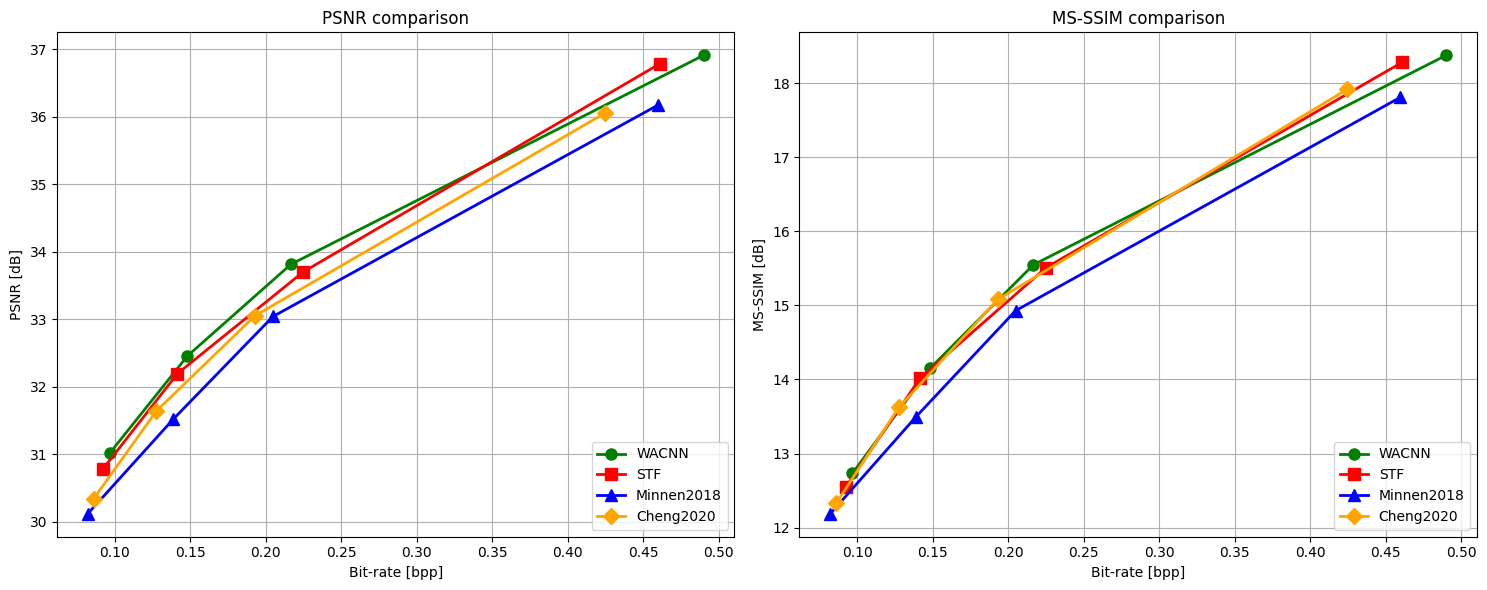

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

all_metrics = {**metrics, **baseline_metrics}

markers = {'WACNN': 'o', 'STF': 's', 'Minnen2018': '^', 'Cheng2020': 'D'}
colors = {'WACNN': 'green', 'STF': 'red', 'Minnen2018': 'blue', 'Cheng2020': 'orange'}

for name, m in all_metrics.items():
    points = sorted(zip(m['bit-rate'], m['psnr'], m['ms-ssim']))
    bit_rates, psnrs, ms_ssims = zip(*points)
    
    # PSNR plot
    axes[0].plot(bit_rates, psnrs, f'-', color=colors[name], marker=markers[name], 
                label=name, markersize=8, linewidth=2)
    axes[0].legend(loc='lower right')
    axes[0].grid(True)
    axes[0].set_ylabel('PSNR [dB]')
    axes[0].set_xlabel('Bit-rate [bpp]')
    axes[0].title.set_text('PSNR comparison')

    # MS-SSIM plot
    ms_ssim_db = [-10*np.log10(1-msssim) for msssim in ms_ssims]
    axes[1].plot(bit_rates, ms_ssim_db, f'-', color=colors[name], marker=markers[name], 
                label=name, markersize=8, linewidth=2)
    axes[1].legend(loc='lower right')
    axes[1].grid(True)
    axes[1].set_ylabel('MS-SSIM [dB]')
    axes[1].set_xlabel('Bit-rate [bpp]')
    axes[1].title.set_text('MS-SSIM comparison')

plt.tight_layout()
plt.show()